In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


Tomando en cuenta que en las condiciones iniciales

In [2]:
g = 9.81
l = 1

h = 0.001

# Usado para las graficas
dot = '\u0307'

E = np.array([1, 3, 5, 10, 15])

d_angle = 10e-15

phi_init = np.array([np.pi/16, np.pi/16 + d_angle])
psi_init = np.array([np.pi/16, np.pi/16 + d_angle])

n_interation = int(10e4)

vec = [$\phi$, $\psi$, $p_\phi$, $p_\psi$]

In [3]:
@jit(nopython = True)
def polar_to_cart (phi):
    x = np.zeros((2, len(phi)))
    for i in range(len(phi)):
        x[0, i] = l * np.cos(phi[i]-np.pi/2)
        x[1, i] = l * np.sin(phi[i]-np.pi/2)
    return x

@jit(nopython = True)
def momento_to_velocidad (vec):
    div = 2-(np.cos(vec[0]-vec[1]))**2
    phi_dot = (vec[2]-vec[3]*np.cos(vec[0]-vec[1]))/div
    psi_dot = (2*vec[3]-vec[2]*np.cos(vec[0]-vec[1]))/div
    return np.array([vec[0], vec[1], phi_dot, psi_dot])

@jit(nopython = True)
def function (vec):
    div = 2-(np.cos(vec[0]-vec[1]))**2
    pphi_dot = 2*np.sin(vec[1]-vec[0])*(vec[2]*vec[3]*(np.cos(vec[0]-vec[1]))**2 - (2*vec[3]**2 + vec[2]**2)*np.cos(vec[0]-vec[1]) + 2*vec[2]*vec[3])/div**2 - 2*g*np.sin(vec[0])
    ppsi_dot = 2*np.sin(vec[0]-vec[1])*(vec[2]*vec[3]*(np.cos(vec[0]-vec[1]))**2 - (2*vec[3]**2 + vec[2]**2)*np.cos(vec[0]-vec[1]) + 2*vec[2]*vec[3])/div**2 - g*np.sin(vec[1]) 
    phi_dot = (vec[2]-vec[3]*np.cos(vec[0]-vec[1]))/div
    psi_dot = (2*vec[3]-vec[2]*np.cos(vec[0]-vec[1]))/div
    return np.array([phi_dot, psi_dot, pphi_dot, ppsi_dot])

@jit(nopython = True)
def Runge_Kutta (vec_angulos, h):
    k_1 = h*function(vec_angulos)
    k_2 = h*function(vec_angulos + k_1/2)
    k_3 = h*function(vec_angulos + k_2/2)
    k_4 = h*function(vec_angulos + k_3)
    return vec_angulos + (k_1 + k_2 + k_3 + k_4)/6

@jit(nopython = True)
def run_code(n, j, k):
    vec_Cohete_total = np.zeros((int(n_interation), 4))

    phi_dot_init = np.sqrt(E[n] - 2*g*(1-np.cos(phi_init[j]))- g*(1-np.cos(psi_init[k])))
    ppsi_init = phi_dot_init*(np.cos(psi_init[k]-phi_init[j]))**2
    pphi_init = 2*phi_dot_init

    vec_Cohete_total[0] = np.array([phi_init[j], psi_init[k], pphi_init, ppsi_init])
    t = 0
    for i in range(n_interation-1):
        vec_Cohete_total[i+1] = Runge_Kutta(vec_Cohete_total[i], h)
        t = t+ h
    return vec_Cohete_total 

def function_fit(x, a):
    return np.exp(a*x)


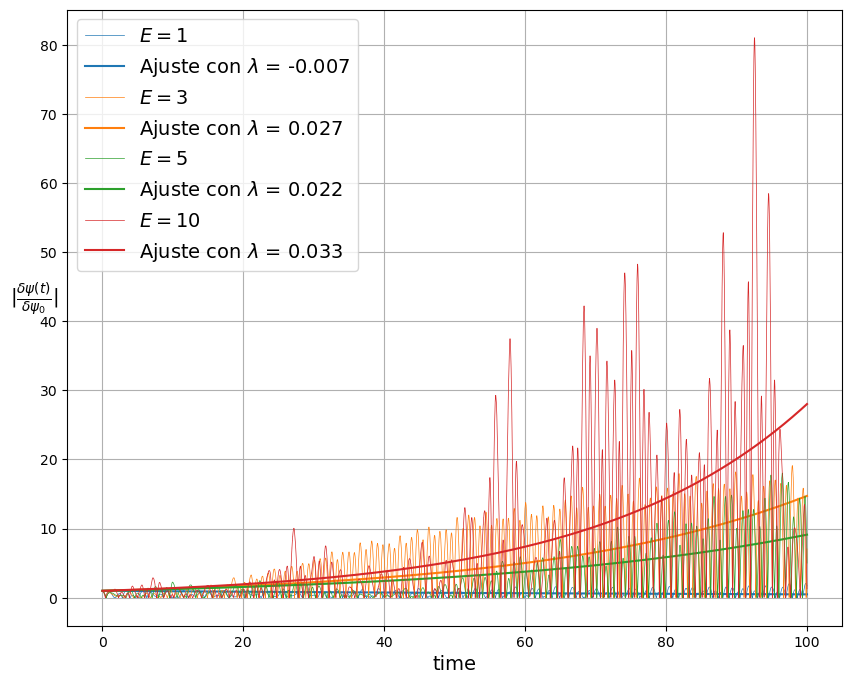

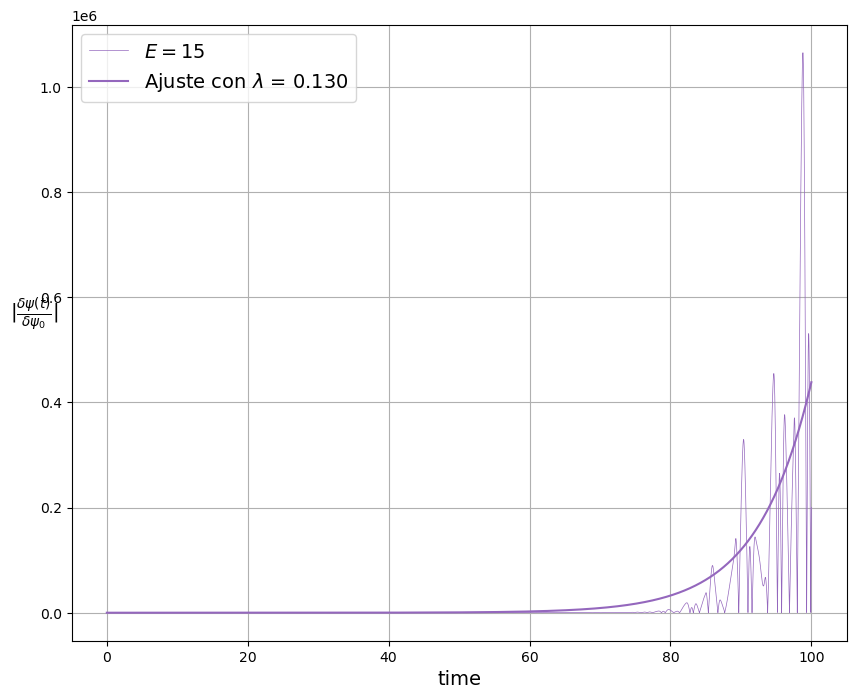

In [4]:
fig=plt.figure(figsize=(10, 8)) #Size of the plot
ax=fig.add_subplot(111)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

time = np.linspace(0, n_interation*h, n_interation)

for i in range(len(E)-1):
    vec_pendulo_1 = run_code(i, 0, 0)
    vec_pendulo_2 = run_code(i, 0, 1)
    diff = vec_pendulo_1 - vec_pendulo_2

    data_psi = np.abs(diff[:,1]/diff[:,1][0])
    plt.plot(time, data_psi, lw=0.5, label=r"$E = {}$".format(E[i]), color=colors[i])
    popt, pcov = curve_fit(function_fit, time, data_psi)
    data_pred = function_fit(time, popt[0])
    plt.plot(time, data_pred, color = colors[i], label=r'Ajuste con $\lambda$ = {:.3f}'.format(popt[0]))

plt.xlabel(r"time", fontsize=14)
plt.ylabel(r"$|\frac{\delta \psi (t)}{\delta \psi_0}|$", fontsize=14, rotation=0)
plt.legend(fontsize=14)
plt.title(r"", fontsize=16)
plt.grid()

plt.savefig("latex/plots/coeficientes_lyapunov_1_4.png", bbox_inches='tight', pad_inches=0.1)

fig=plt.figure(figsize=(10, 8)) #Size of the plot
ax=fig.add_subplot(111)

vec_pendulo_1 = run_code(4, 0, 0)
vec_pendulo_2 = run_code(4, 0, 1)
diff = vec_pendulo_1 - vec_pendulo_2

data_psi = np.abs(diff[:,1]/diff[:,1][0])
plt.plot(time, data_psi, lw=0.5, label=r"$E = {}$".format(E[4]), color=colors[4])
popt, pcov = curve_fit(function_fit, time, data_psi)
data_pred = function_fit(time, popt[0])
plt.plot(time, data_pred, color = colors[4], label=r'Ajuste con $\lambda$ = {:.3f}'.format(popt[0]))
plt.xlabel(r"time", fontsize=14)
plt.ylabel(r"$|\frac{\delta \psi (t)}{\delta \psi_0}|$", fontsize=14, rotation=0)
plt.legend(fontsize=14)
plt.title(r"", fontsize=16)
plt.grid()

plt.savefig("latex/plots/coeficientes_lyapunov_5.png", bbox_inches='tight', pad_inches=0.1)